In [1]:
# Import packages 
import pandas as pd
import geopandas as gpd
import os
import numpy as np
import matplotlib.pyplot as plt
from mgwr.sel_bw import Sel_BW
from mgwr.gwr import GWR, MGWR
import statsmodels.api as sm

<jemalloc>: MADV_DONTNEED does not work (memset will be used instead)
<jemalloc>: (This is the expected behaviour if you are running under QEMU)


In [2]:
# Load the main shapefile
gdf = gpd.read_file('s1.shp')

In [3]:
# Rename columns
gdf=gdf.rename(columns={'1_Score':'Overallscore',
                      '1_Access':'Access',
                        '1_PM25':'PM25',
                        '1_Cycling':'Cycling',
                        '1_Pedestri':'Pedestrian',
                        '1_Rail':'Rail',
                        '1_Road':'Road',
                        '1_Conserva':'Conservation',
                        '1_UHI':'UHI',
                        '1_SAMHI201':'SAMHI2011',
                        '1_SAMHI2_1':'SAMHI2012',
                        '1_SAMHI2_2':'SAMHI2013',
                        '1_SAMHI2_3':'SAMHI2014',
                        '1_SAMHI2_4':'SAMHI2015',
                        '1_SAMHI2_5':'SAMHI2016',
                        '1_SAMHI2_6':'SAMHI2017',
                        '1_SAMHI2_7':'SAMHI2018',
                        '1_SAMHI2_8':'SAMHI2019',
                        '1_imd_Inco':'Income',
                       '1_imd_Empl':'Employment'})
gdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 632 entries, 0 to 631
Data columns (total 25 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   NAME          632 non-null    object  
 1   GSS_CODE      632 non-null    object  
 2   DISTRICT      632 non-null    object  
 3   1_NAME        632 non-null    object  
 4   Overallscore  632 non-null    object  
 5   Access        632 non-null    object  
 6   PM25          632 non-null    object  
 7   Cycling       632 non-null    object  
 8   Pedestrian    631 non-null    object  
 9   Rail          545 non-null    object  
 10  Road          631 non-null    object  
 11  Conservation  632 non-null    object  
 12  UHI           632 non-null    object  
 13  SAMHI2011     632 non-null    object  
 14  SAMHI2012     632 non-null    object  
 15  SAMHI2013     632 non-null    object  
 16  SAMHI2014     632 non-null    object  
 17  SAMHI2015     632 non-null    object  
 18  SA

In [4]:
# Change datatype to numeric type
for column in gdf.columns[4:24]:
    gdf[column] = pd.to_numeric(gdf[column], errors='coerce')

In [5]:
# Dropping rows with missing values
gdf = gdf.dropna()

In [6]:
# Compute the centroid for each row and store in a new column 'centro'
gdf['centro']=gdf.centroid

# Extract the x and y coordinate of each centroid and store in a new column 'X' and 'Y'
gdf['X']=gdf.centro.x
gdf['Y']=gdf.centro.y

# Create tuples
coords = list(zip(gdf['X'],gdf['Y']))


In [7]:
gdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 545 entries, 0 to 630
Data columns (total 28 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   NAME          545 non-null    object  
 1   GSS_CODE      545 non-null    object  
 2   DISTRICT      545 non-null    object  
 3   1_NAME        545 non-null    object  
 4   Overallscore  545 non-null    float64 
 5   Access        545 non-null    float64 
 6   PM25          545 non-null    float64 
 7   Cycling       545 non-null    float64 
 8   Pedestrian    545 non-null    float64 
 9   Rail          545 non-null    float64 
 10  Road          545 non-null    float64 
 11  Conservation  545 non-null    float64 
 12  UHI           545 non-null    float64 
 13  SAMHI2011     545 non-null    float64 
 14  SAMHI2012     545 non-null    float64 
 15  SAMHI2013     545 non-null    float64 
 16  SAMHI2014     545 non-null    float64 
 17  SAMHI2015     545 non-null    float64 
 18  SA

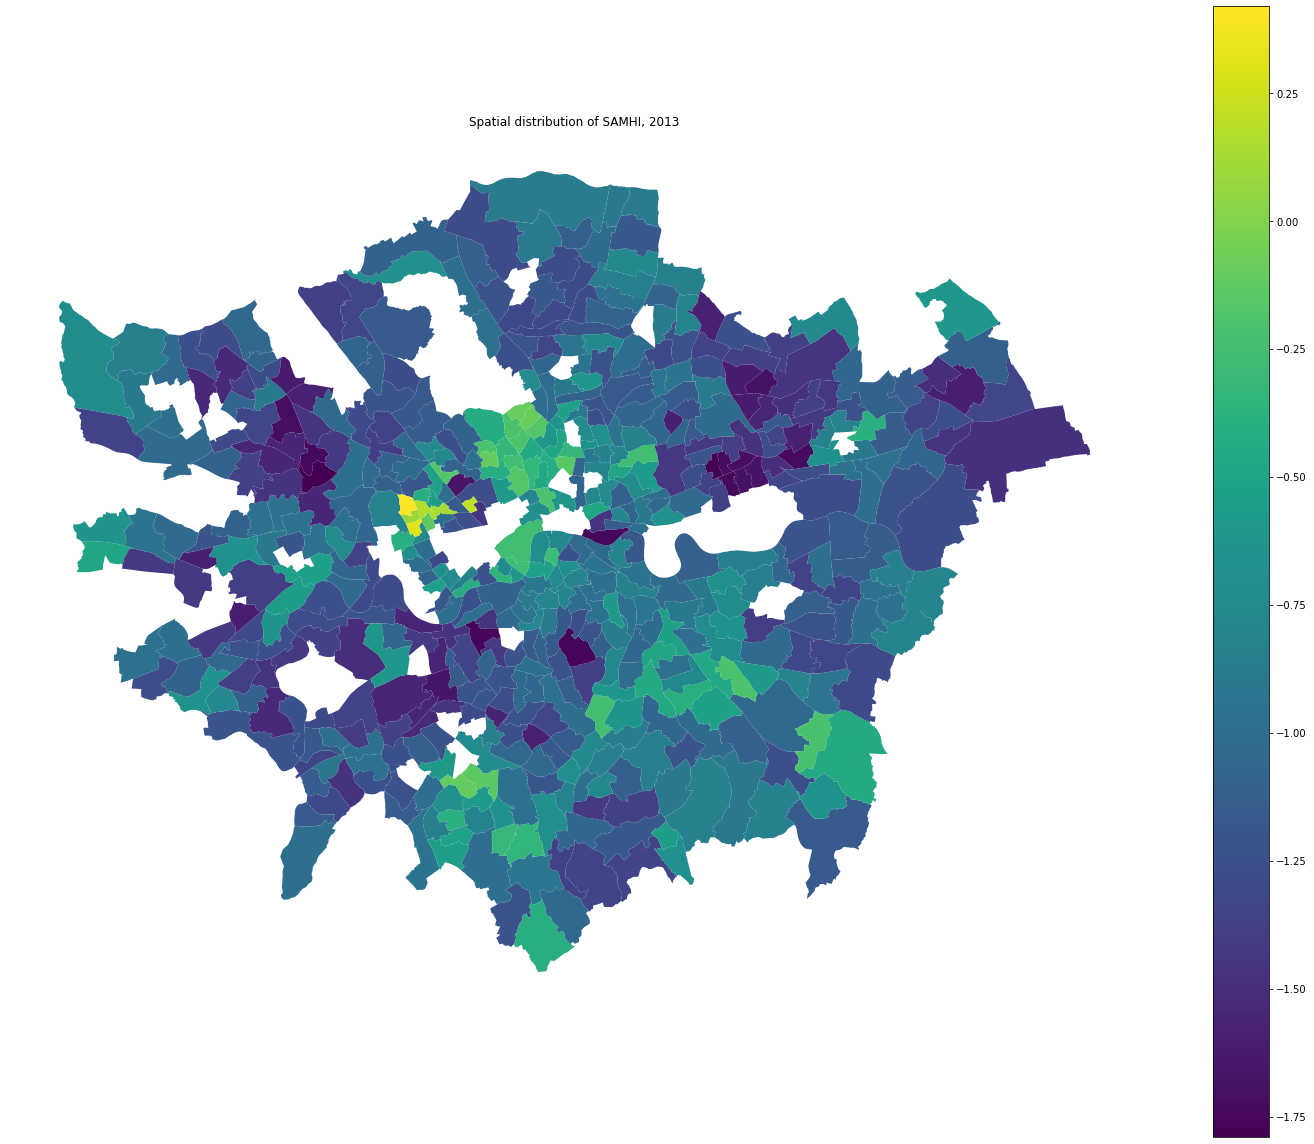

In [8]:
# Plot the spatial distribution of SAMHI 2013
fig, ax = plt.subplots(figsize=(20, 16))

gdf.plot(column='SAMHI2013', ax=ax, legend=True, cmap='viridis')
ax.set_title('Spatial distribution of SAMHI, 2013')
ax.axis('off')  

plt.tight_layout()
plt.savefig('SAMHI.png')
plt.show()

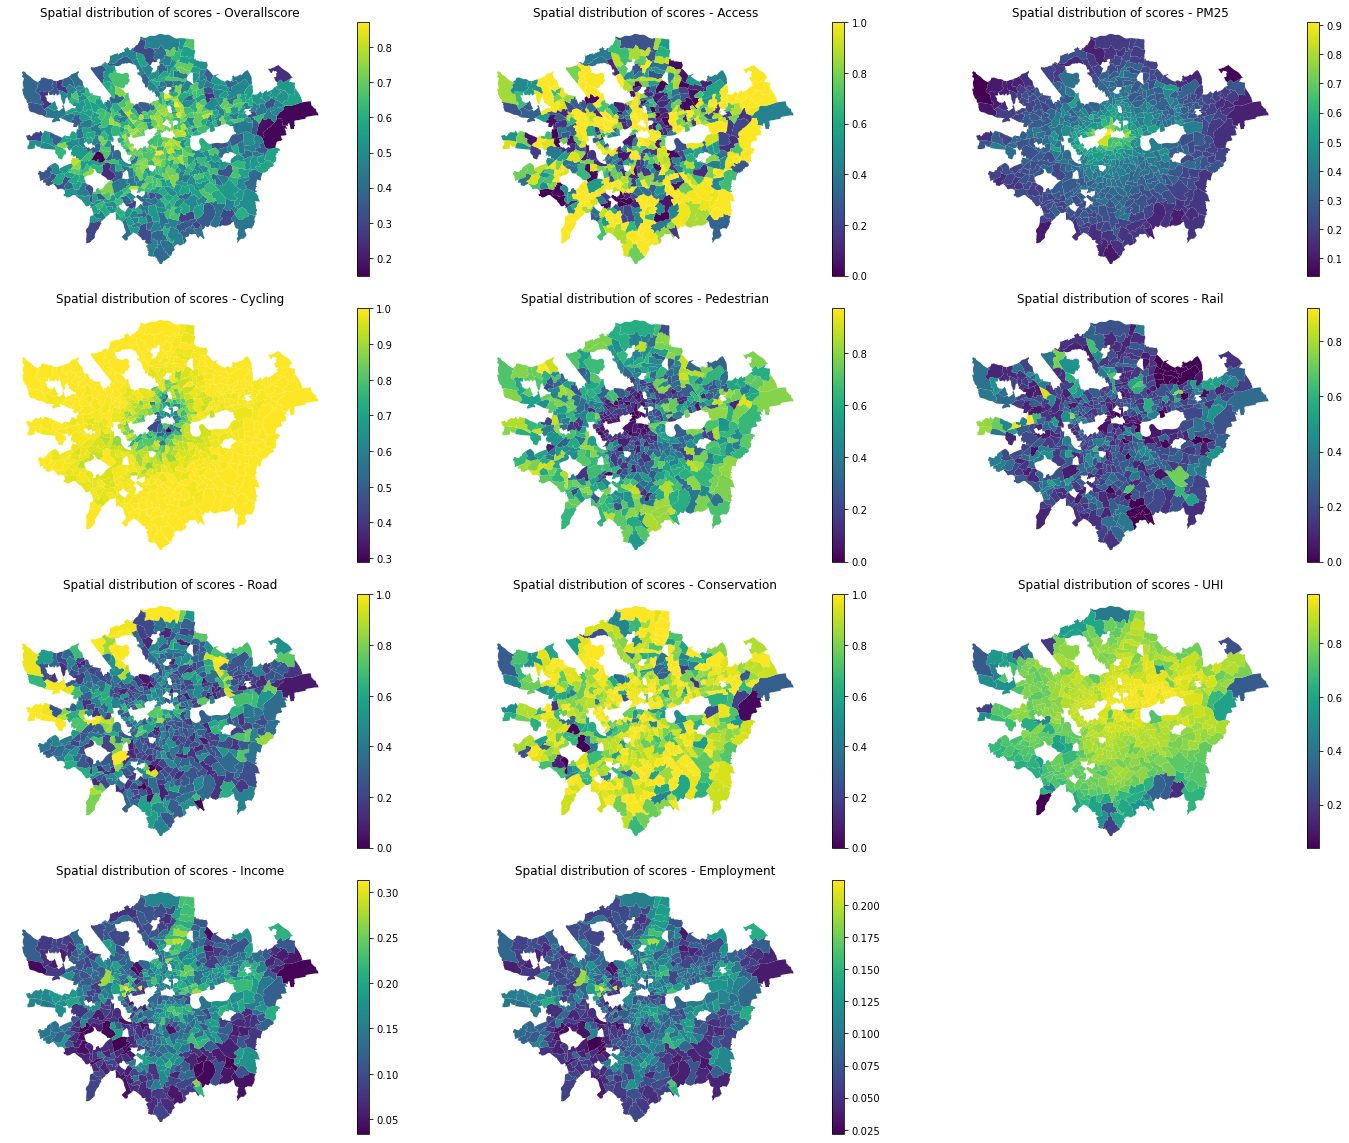

In [9]:
# Plot the spatial distribution of variables

columns_to_plot = ['Overallscore', 'Access', 'PM25', 'Cycling', 'Pedestrian', 'Rail', 'Road', 'Conservation', 'UHI', 'Income', 'Employment']

fig, axs = plt.subplots(4, 3, figsize=(20, 16))
axs = axs.flatten()  # to make indexing easier

for i, column in enumerate(columns_to_plot):
    gdf.plot(column=column, ax=axs[i], legend=True, cmap='viridis')
    axs[i].set_title(f'Spatial distribution of scores - {column}')
    axs[i].axis('off')  

axs[-1].set_visible(False)

plt.tight_layout()
plt.savefig('scores.png')
plt.show()



In [10]:
# Function to compute VIF

from statsmodels.stats.outliers_influence import variance_inflation_factor 
from statsmodels.tools.tools import add_constant

def drop_column_using_vif_(df, thresh=5):
   
    while True:
        df_with_const = add_constant(df)

        vif_df = pd.Series([variance_inflation_factor(df_with_const.values, i) 
               for i in range(df_with_const.shape[1])], name= "VIF",
              index=df_with_const.columns).to_frame()

        vif_df = vif_df.drop('const')
        
        if vif_df.VIF.max() > thresh:
            index_to_drop = vif_df.index[vif_df.VIF == vif_df.VIF.max()].tolist()[0]
            print('Dropping: {}'.format(index_to_drop))
            df = df.drop(columns = index_to_drop)
        else:
            break

    return df

In [11]:
# Select columns for examine multicollinearity
selected_columns = ['Overallscore', 'Access', 'PM25', 'Cycling', 'Pedestrian', 'Rail', 'Road', 'Conservation', 'UHI', 'SAMHI2013', 'Income', 'Employment'] 
multi = gdf[selected_columns]

multi.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 545 entries, 0 to 630
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Overallscore  545 non-null    float64
 1   Access        545 non-null    float64
 2   PM25          545 non-null    float64
 3   Cycling       545 non-null    float64
 4   Pedestrian    545 non-null    float64
 5   Rail          545 non-null    float64
 6   Road          545 non-null    float64
 7   Conservation  545 non-null    float64
 8   UHI           545 non-null    float64
 9   SAMHI2013     545 non-null    float64
 10  Income        545 non-null    float64
 11  Employment    545 non-null    float64
dtypes: float64(12)
memory usage: 55.4 KB


In [12]:
# Drop columns that may cause multicollinearity
multi = drop_column_using_vif_(multi)
print("The columns remaining after VIF selection are:")
print(multi.columns)

Dropping: Employment
The columns remaining after VIF selection are:
Index(['Overallscore', 'Access', 'PM25', 'Cycling', 'Pedestrian', 'Rail',
       'Road', 'Conservation', 'UHI', 'SAMHI2013', 'Income'],
      dtype='object')


In [13]:
# Multiple linear regression - model 1
model1= sm.formula.ols('SAMHI2013 ~ Access + PM25 + Conservation + UHI + Rail + Road', multi).fit()
model1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              SAMHI2013   R-squared:                       0.107
Model:                            OLS   Adj. R-squared:                  0.097
Method:                 Least Squares   F-statistic:                     10.76
Date:                Sun, 20 Aug 2023   Prob (F-statistic):           2.58e-11
Time:                        20:33:54   Log-Likelihood:                -206.64
No. Observations:                 545   AIC:                             427.3
Df Residuals:                     538   BIC:                             457.4
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       -0.8592      0.127     -6.772      0.000      -1.108      -0.610
Access          -0.0850      0.047     -1.791      0.074      -0.178       0.008
PM25             1.1393      0.157      7.246      0.000       0.830       1.448
Conservation     0.2141      0.088      2.438      0.015       0.042       0.387
UHI             -0.7290      0.163     -4.465      0.000      -1.050      -0.408
Rail             0.0519      0.099      0.524      0.601      -0.143       0.246
Road            -0.2333      0.076     -3.061      0.002      -0.383      -0.084
==============================================================================
Omnibus:                       23.408   Durbin-Watson:                   1.311
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               26.488
Skew:                           0.459   Prob(JB):                     1.77e-06
Kurtosis:                       3.569   Cond. No.                         26.3
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [14]:
# Multiple linear regression - model 2
model2= sm.formula.ols('SAMHI2013 ~ Access + PM25 + Conservation + UHI + Rail + Road + Cycling + Pedestrian', multi).fit()
model2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              SAMHI2013   R-squared:                       0.121
Model:                            OLS   Adj. R-squared:                  0.108
Method:                 Least Squares   F-statistic:                     9.263
Date:                Sun, 20 Aug 2023   Prob (F-statistic):           5.40e-12
Time:                        20:33:54   Log-Likelihood:                -202.23
No. Observations:                 545   AIC:                             422.5
Df Residuals:                     536   BIC:                             461.2
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       -0.1051      0.288     -0.364      0.716      -0.672       0.462
Access          -0.0995      0.047     -2.099      0.036      -0.193      -0.006
PM25             0.5929      0.242      2.449      0.015       0.117       1.069
Conservation     0.2019      0.089      2.268      0.024       0.027       0.377
UHI             -0.6179      0.168     -3.674      0.000      -0.948      -0.288
Rail             0.0887      0.099      0.894      0.372      -0.106       0.284
Road            -0.1880      0.079     -2.394      0.017      -0.342      -0.034
Cycling         -0.6555      0.253     -2.594      0.010      -1.152      -0.159
Pedestrian      -0.0980      0.085     -1.148      0.251      -0.266       0.070
==============================================================================
Omnibus:                       33.260   Durbin-Watson:                   1.316
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               41.051
Skew:                           0.545   Prob(JB):                     1.22e-09
Kurtosis:                       3.786   Cond. No.                         55.5
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [15]:
# Multiple linear regression - model 3
model3= sm.formula.ols('SAMHI2013 ~ Access + PM25 + Conservation + UHI + Rail + Road + Cycling + Pedestrian + Income', multi).fit()
model3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              SAMHI2013   R-squared:                       0.370
Model:                            OLS   Adj. R-squared:                  0.360
Method:                 Least Squares   F-statistic:                     34.97
Date:                Sun, 20 Aug 2023   Prob (F-statistic):           1.57e-48
Time:                        20:33:54   Log-Likelihood:                -111.45
No. Observations:                 545   AIC:                             242.9
Df Residuals:                     535   BIC:                             285.9
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       -0.1051      0.244     -0.430      0.667      -0.585       0.375
Access          -0.0479      0.040     -1.187      0.236      -0.127       0.031
PM25             0.4502      0.205      2.191      0.029       0.047       0.854
Conservation     0.1785      0.075      2.366      0.018       0.030       0.327
UHI             -1.1407      0.147     -7.762      0.000      -1.429      -0.852
Rail             0.0678      0.084      0.807      0.420      -0.097       0.233
Road            -0.2337      0.067     -3.507      0.000      -0.365      -0.103
Cycling         -0.6799      0.214     -3.175      0.002      -1.100      -0.259
Pedestrian      -0.0850      0.072     -1.175      0.241      -0.227       0.057
Income           3.6287      0.250     14.543      0.000       3.139       4.119
==============================================================================
Omnibus:                        7.792   Durbin-Watson:                   1.044
Prob(Omnibus):                  0.020   Jarque-Bera (JB):                7.820
Skew:                           0.293   Prob(JB):                       0.0200
Kurtosis:                       3.034   Cond. No.                         55.6
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [16]:
# Multiple linear regression - model 4
model4= sm.formula.ols('SAMHI2013 ~  PM25 + Conservation + UHI + Road + Cycling + Income', multi).fit()
model4.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              SAMHI2013   R-squared:                       0.367
Model:                            OLS   Adj. R-squared:                  0.360
Method:                 Least Squares   F-statistic:                     51.93
Date:                Sun, 20 Aug 2023   Prob (F-statistic):           2.10e-50
Time:                        20:33:54   Log-Likelihood:                -113.01
No. Observations:                 545   AIC:                             240.0
Df Residuals:                     538   BIC:                             270.1
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       -0.2037      0.237     -0.859      0.391      -0.669       0.262
PM25             0.5428      0.194      2.800      0.005       0.162       0.924
Conservation     0.1666      0.070      2.380      0.018       0.029       0.304
UHI             -1.1239      0.147     -7.664      0.000      -1.412      -0.836
Road            -0.2475      0.065     -3.836      0.000      -0.374      -0.121
Cycling         -0.6684      0.211     -3.170      0.002      -1.083      -0.254
Income           3.6582      0.249     14.719      0.000       3.170       4.146
==============================================================================
Omnibus:                        7.064   Durbin-Watson:                   1.038
Prob(Omnibus):                  0.029   Jarque-Bera (JB):                6.946
Skew:                           0.270   Prob(JB):                       0.0310
Kurtosis:                       3.117   Cond. No.                         50.0
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [17]:
# Function to convert given columns to numeric type
def convert_to_numeric(column):
    column = pd.to_numeric(column, errors='coerce')
    return column.fillna(column.mean())


# Convert to numeric type
PM25 = convert_to_numeric(gdf['PM25']).values.reshape((-1,1))
Cycling = convert_to_numeric(gdf['Cycling']).values.reshape((-1,1))
Road = convert_to_numeric(gdf['Road']).values.reshape((-1,1))
Conservation = convert_to_numeric(gdf['Conservation']).values.reshape((-1,1))
UHI = convert_to_numeric(gdf['UHI']).values.reshape((-1,1))
Income = convert_to_numeric(gdf['Income']).values.reshape((-1,1))

X = np.hstack([PM25, Cycling, Road, Conservation, UHI, Income])

# Normalisation
X = (X - X.mean(axis=0)) / X.std(axis=0)

# Convert 'SAMHI2013' to numeric type
# Normalisation
y = convert_to_numeric(gdf['SAMHI2013']).values.reshape((-1,1))
y = (y - y.mean(axis=0)) / y.std(axis=0)



In [18]:
# Bandwidth Selection of GWR
sel = Sel_BW(coords, y, X)
bw = sel.search()
print('bw:', bw)

# Fit the GWR model
gwr = GWR(coords, y, X, bw)
gwr_results = gwr.fit()

# Print relevant results
print('aicc:', gwr_results.aicc)
print('ENP:', gwr_results.ENP)
print('sigma2:', gwr_results.sigma2)

bw: 60.0
aicc: 1070.0805633706648
ENP: 136.49825727346374
sigma2: 0.28290838328257056


In [19]:
gwr_results.summary()

Model type                                                         Gaussian
Number of observations:                                                 545
Number of covariates:                                                     7

Global Regression Results
---------------------------------------------------------------------------
Residual sum of squares:                                            345.122
Log-likelihood:                                                    -648.820
AIC:                                                               1311.639
AICc:                                                              1313.908
BIC:                                                              -3044.701
R2:                                                                   0.367
Adj. R2:                                                              0.360

Variable                              Est.         SE  t(Est/SE)    p-value
------------------------------- ---------- ---------- ------

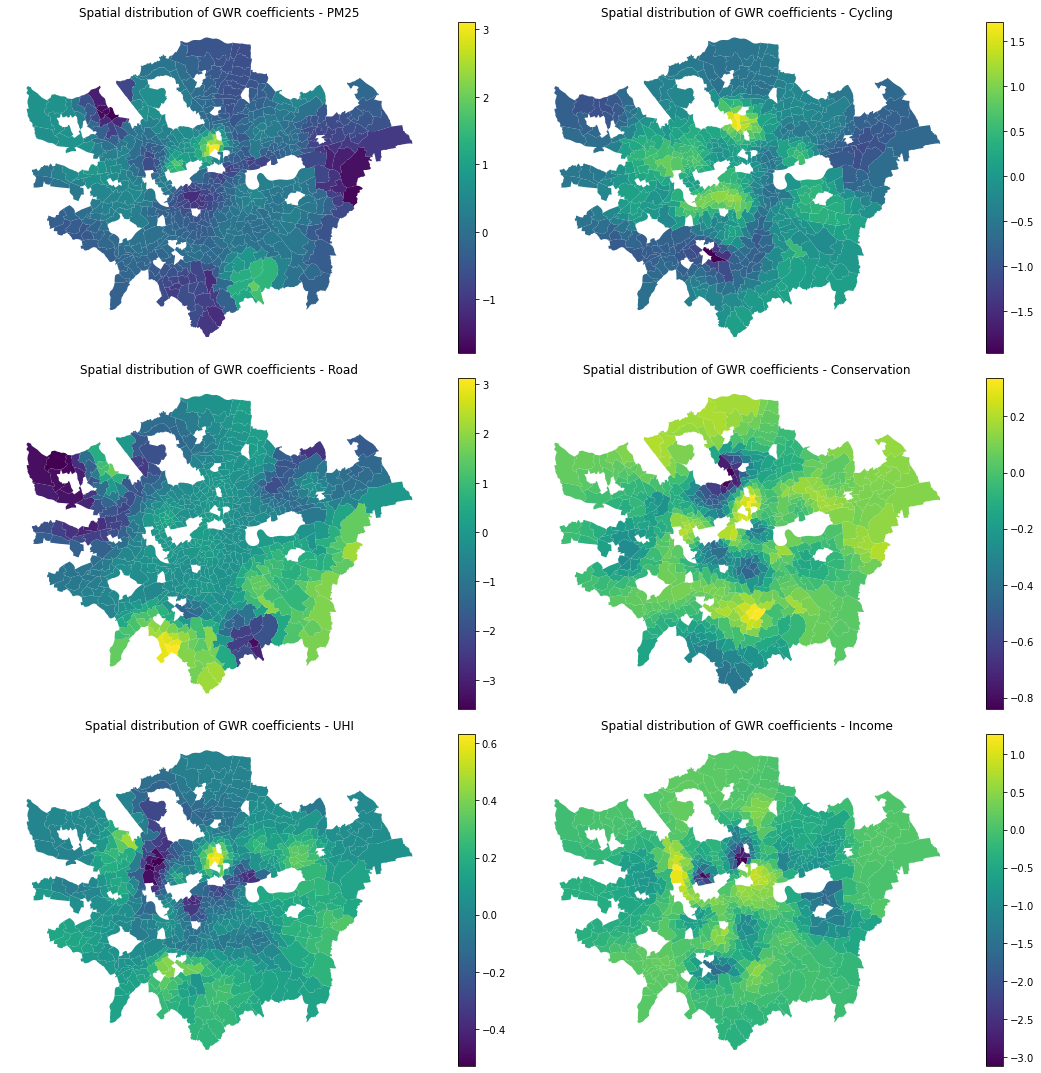

In [20]:
# Plot the coefficients of variables of GWR results

params = gwr_results.params
variable_names = ['PM25', 'Cycling', 'Road', 'Conservation', 'UHI', 'Income']

for i, var_name in enumerate(variable_names):
    gdf[var_name+'_coef'] = params[:, i]

fig, axs = plt.subplots(3, 2, figsize=(15, 15))  
axs = axs.flatten()

for i, var_name in enumerate(variable_names):
    gdf.plot(column=var_name+'_coef', ax=axs[i], legend=True, cmap='viridis')
    axs[i].set_title(f'Spatial distribution of GWR coefficients - {var_name}')
    axs[i].axis('off') 

if len(variable_names) % 2 == 1:
    fig.delaxes(axs[-1]) 

plt.tight_layout()
plt.savefig('GWR.png')
plt.show()